In [1]:
import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import argparse
import awkward as ak
import numpy as np
import pandas as pd
import vector
import mplhep as hep
import torch
import os
import os.path as osp

In [2]:
def zero_pad(arr, max_nconstit=128):
    """
    arr: numpy array
    """
    arr = arr[:max_nconstit]
    if arr.shape[0] < max_nconstit:
        zeros = np.zeros([max_nconstit - arr.shape[0],1])
        padded_arr = np.concatenate((arr, zeros), axis=0)
        return padded_arr
    else:
        return arr

In [3]:
"""Runs data processing scripts to turn raw data from (../raw) into
cleaned data ready to be analyzed (saved in ../processed).
Convert h5 to pt files, each containing 100k zero-padded jets cropped to 128 constituents
Shape: (100k, 7, 128)
"""
logger = logging.getLogger(__name__)
logger.info("making final data set from raw data")
label = "test"
hdf5_file = f"/ssl-jet-vol-v2/toptagging/{label}/raw/{label}.h5"
vector.register_awkward()

print("reading h5 file")
df = pd.read_hdf(hdf5_file, key="table")
print("finished reading h5 file")

reading h5 file
finished reading h5 file


In [4]:
def _col_list(prefix, max_particles=200):
    return ["%s_%d" % (prefix, i) for i in range(max_particles)]

_px = df[_col_list("PX")].values
_py = df[_col_list("PY")].values
_pz = df[_col_list("PZ")].values
_e = df[_col_list("E")].values

mask = _e > 0
n_particles = np.sum(mask, axis=1)

px = ak.unflatten(_px[mask], n_particles)
py = ak.unflatten(_py[mask], n_particles)
pz = ak.unflatten(_pz[mask], n_particles)
energy = ak.unflatten(_e[mask], n_particles)

p4 = ak.zip(
    {
        "px": px,
        "py": py,
        "pz": pz,
        "energy": energy,
    },
    with_name="Momentum4D",
)

jet_p4 = ak.sum(p4, axis=-1)

In [6]:
import tqdm
# outputs
v = {}
v["label"] = df["is_signal_new"].values

v["jet_pt"] = jet_p4.pt.to_numpy()
v["jet_eta"] = jet_p4.eta.to_numpy()
v["jet_phi"] = jet_p4.phi.to_numpy()
v["jet_energy"] = jet_p4.energy.to_numpy()
v["jet_mass"] = jet_p4.mass.to_numpy()
v["jet_nparticles"] = n_particles

v["part_px"] = px
v["part_py"] = py
v["part_pz"] = pz
v["part_energy"] = energy

# dim 1 ordering: 'part_deta','part_dphi','part_pt_log', 'part_e_log', 'part_logptrel', 'part_logerel','part_deltaR'
v["part_eta"] = p4.eta
v["part_phi"] = p4.phi
v["part_pt"] = np.hypot(v["part_px"], v["part_py"])
v["part_pt_log"] = np.log(v["part_pt"])
v["part_e_log"] = np.log(v["part_energy"])
v["part_logptrel"] = np.log(v["part_pt"] / v["jet_pt"])
v["part_logerel"] = np.log(v["part_energy"] / v["jet_energy"])
v["part_deltaR"] = np.sqrt(np.square(v["part_eta"]) + np.square(v["part_phi"]))

In [30]:
len(v["part_pt"])

404000

## Explore the dataset

In [21]:
flat_pT_array = ak.flatten(v["part_pt_log"])

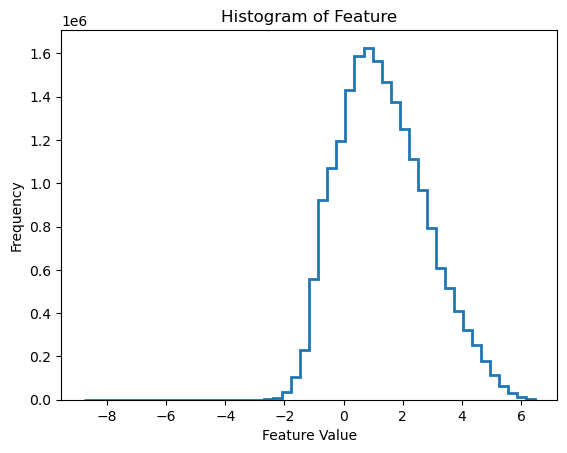

In [22]:
import matplotlib.pyplot as plt
# Plot the histogram
plt.hist(flat_pT_array, bins=50, histtype='step', linewidth=2)
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.title('Histogram of Feature')
plt.show()

feature part_eta


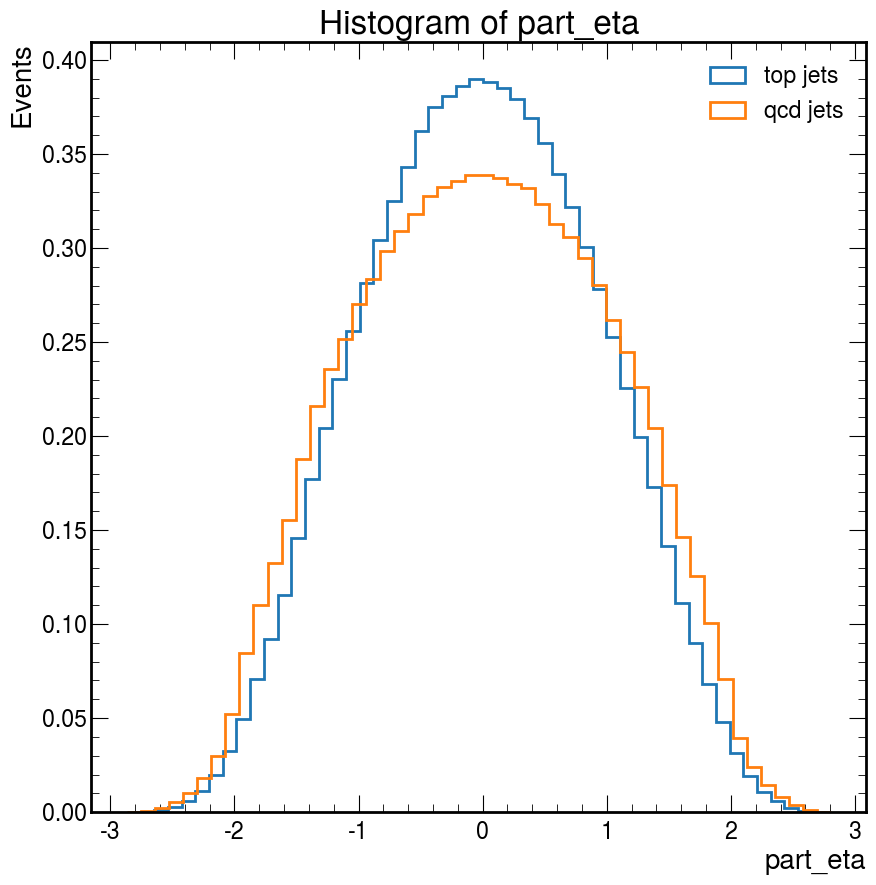

feature part_phi


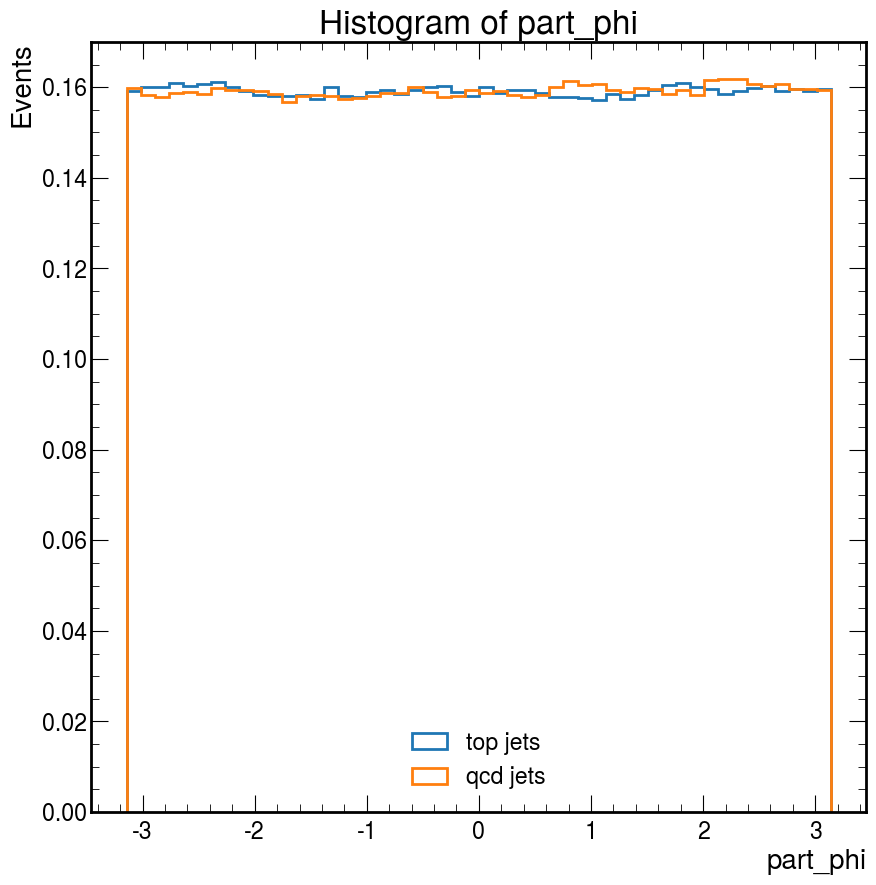

feature part_pt_log


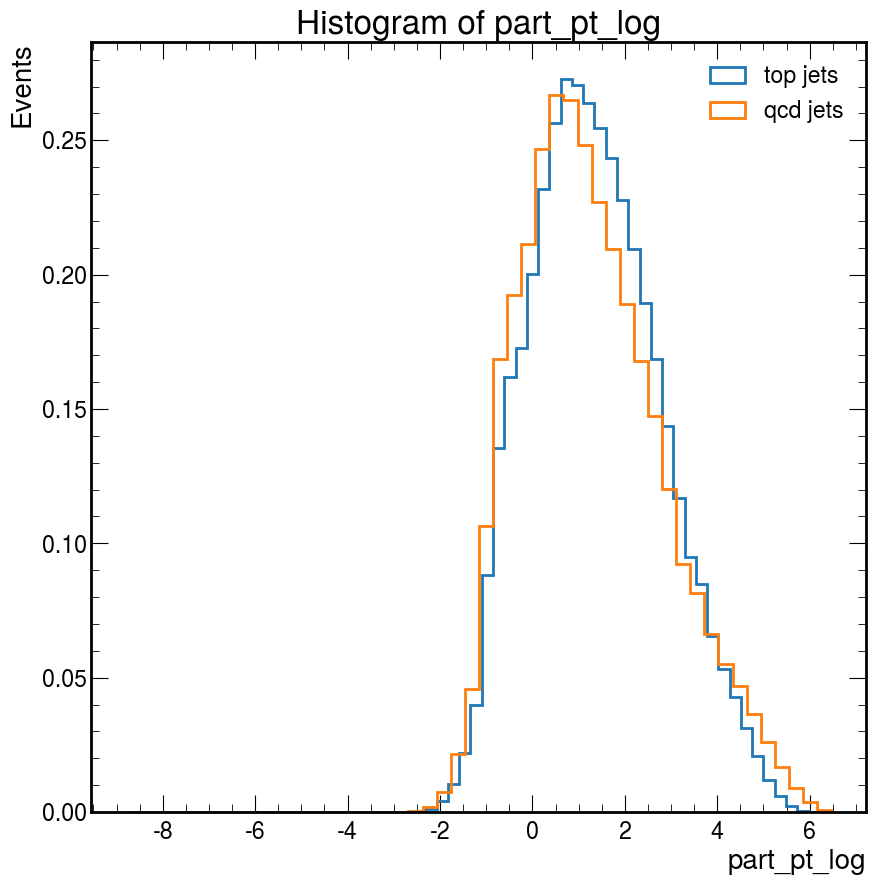

feature part_e_log


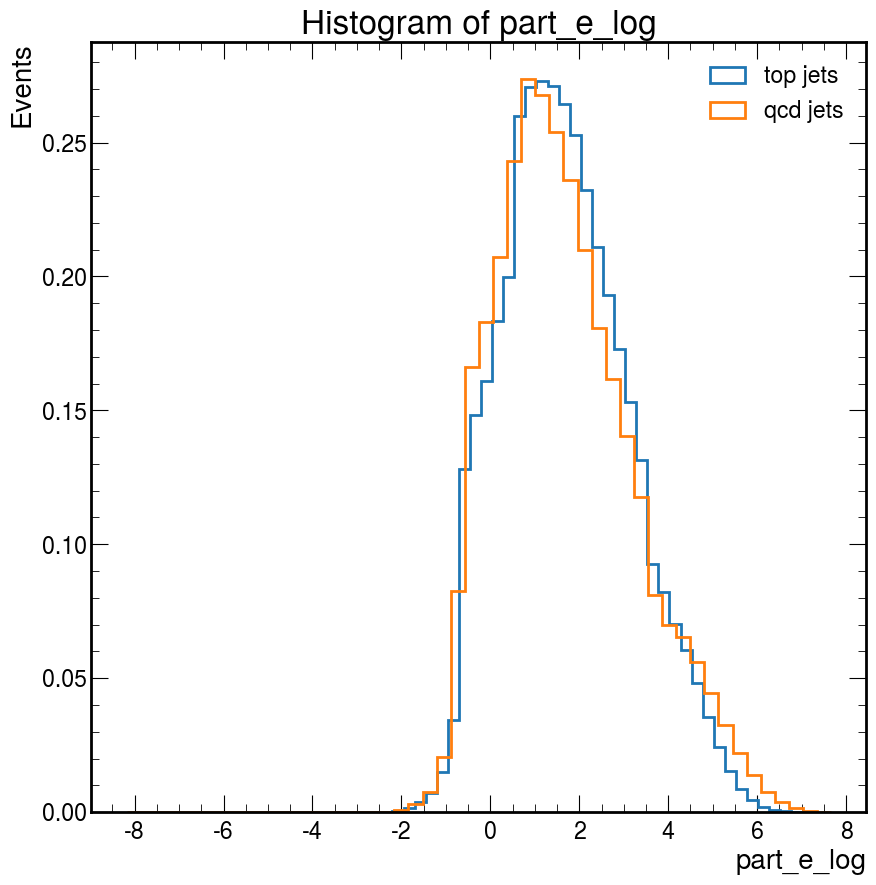

feature part_logptrel


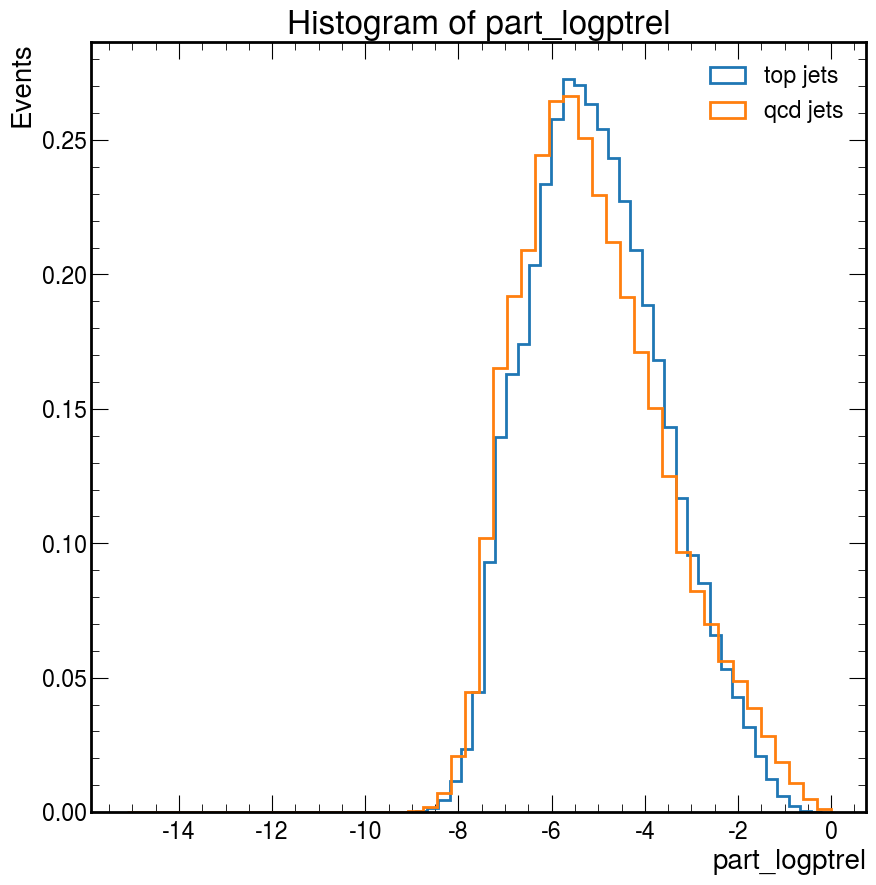

feature part_logerel


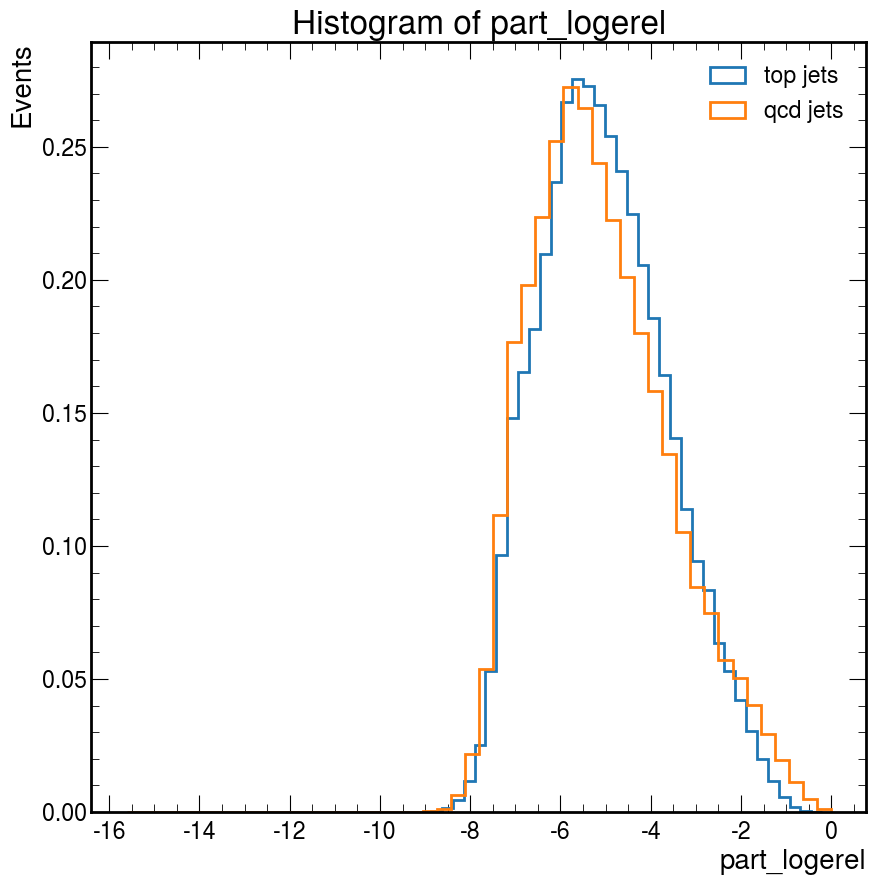

feature part_deltaR


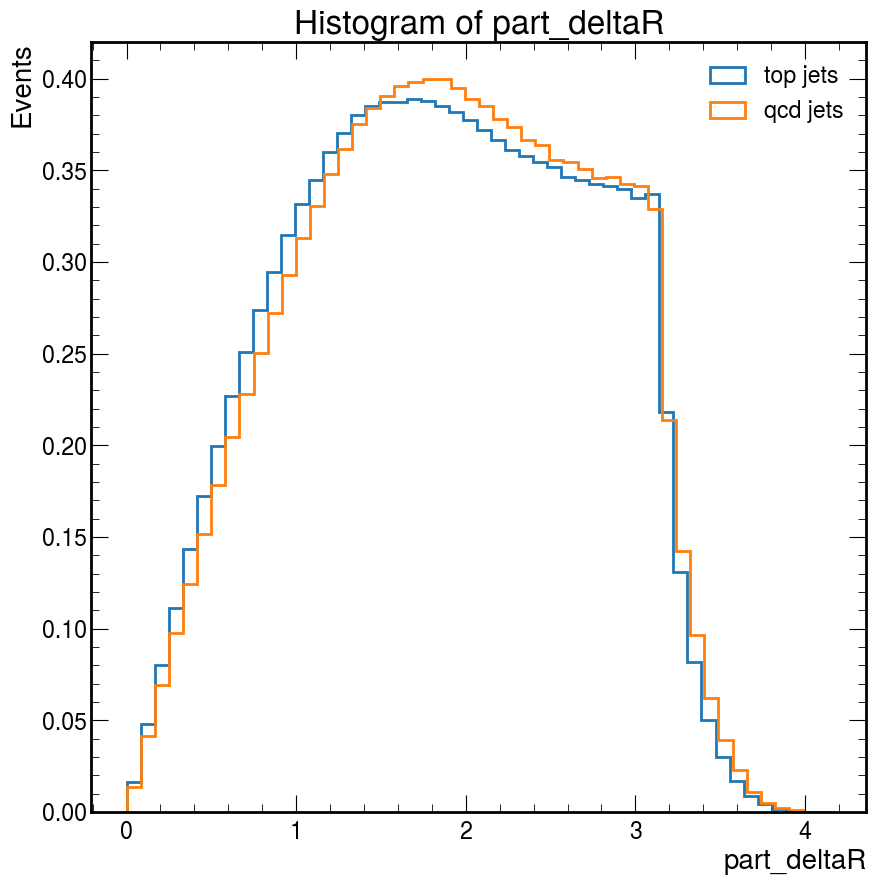

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import os
import mplhep as hep

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})
save_dir = save_path = "../plots/dataset_visaulization"
os.system(f"mkdir -p {save_path}")  # -p: create parent dirs if needed, exist_ok
# Assuming 'v' is your dictionary and 'df' is a pandas DataFrame with labels
# Assuming 'px', 'py', 'pz', 'energy', 'p4', 'jet_p4', and 'n_particles' are already defined and filled
# Ensure 'save_dir' is defined and points to the desired save directory

# Create the histograms
features = ['part_eta', 'part_phi', 'part_pt_log', 'part_e_log', 'part_logptrel', 'part_logerel', 'part_deltaR']
labels = v["label"]

for feature in features:
    print(f"feature {feature}")
    # Separate the data for the two classes
    data_top = v[feature][labels == 1]
    data_qcd = v[feature][labels == 0]
    
    # Flatten the awkward arrays
    flat_data_top = ak.flatten(data_top)
    flat_data_qcd = ak.flatten(data_qcd)
    
    # Create the histogram
    plt.figure()
    plt.hist(flat_data_top, bins=50, density=True, histtype='step', linewidth=2, label='top jets', linestyle='-')
    plt.hist(flat_data_qcd, bins=50, density=True, histtype='step', linewidth=2, label='qcd jets', linestyle='-')
    plt.xlabel(f'{feature}')
    plt.ylabel('Events')
    plt.title(f'Histogram of {feature}')
    plt.legend()
    
    # Save the figure
    plt.savefig(os.path.join(save_dir, f'histogram_{feature}.png'))
    plt.show()
    plt.close()


In [31]:
# check particle multiplicity for top quark jets vs qcd jets
multiplicity = {}
multiplicity["top"] = []
multiplicity["qcd"] = []
data_top = v["part_pt"][labels == 1]
data_qcd = v["part_pt"][labels == 0]

In [32]:
len(data_top)

202086

In [33]:
len(data_qcd)

201914

In [35]:
for i in range(len(data_top)):
    multiplicity["top"].append(len(data_top[i])) 
for i in range(len(data_top)):
    multiplicity["qcd"].append(len(data_qcd[i]))


IndexError: cannot slice ListArray (of length 201914) with 201914

This error occurred while attempting to slice

    <Array [[205, 145, ..., 0.913, 0.448], ...] type='201914 * var * float32'>

with

    201914

In [38]:
len(multiplicity["qcd"])

201914

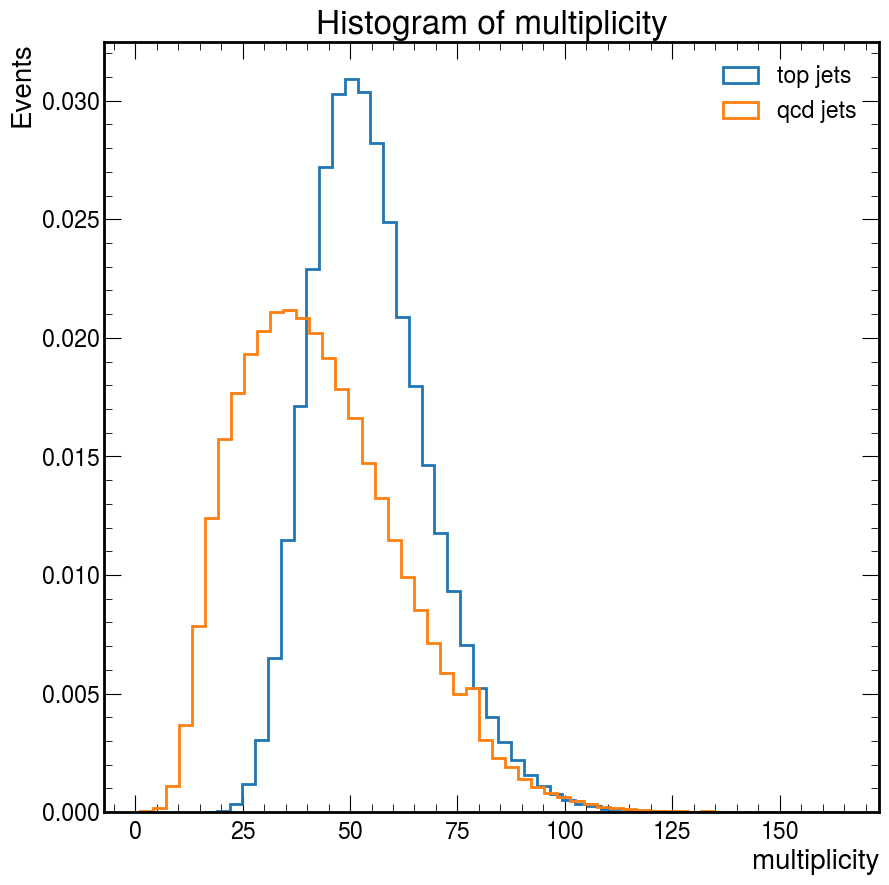

In [43]:
plt.figure()
plt.hist(multiplicity["top"], bins=50, density=True, histtype='step', linewidth=2, label='top jets', linestyle='-')
plt.hist(multiplicity["qcd"], bins=50, density=True, histtype='step', linewidth=2, label='qcd jets', linestyle='-')
plt.xlabel('multiplicity')
plt.ylabel('Events')
plt.title(f'Histogram of multiplicity')
plt.legend()

# Save the figure
plt.savefig(os.path.join(save_dir, f'histogram_multiplicity.png'))
plt.show()
plt.close()

In [9]:
np.sum(np.exp(v["part_logptrel"][2]))

1.0041448

In [10]:
np.sum(np.exp(v["part_logerel"][2]))

1.0

In [11]:
v["part_eta"][0].to_numpy().shape

(23,)

In [12]:
jet_index = 0
part_eta = zero_pad(
    v["part_eta"][jet_index].to_numpy().reshape(-1, 1)
)
part_phi = zero_pad(
    v["part_phi"][jet_index].to_numpy().reshape(-1, 1)
)
part_pt_log = zero_pad(
    v["part_pt_log"][jet_index].to_numpy().reshape(-1, 1)
)
part_e_log = zero_pad(
    v["part_e_log"][jet_index].to_numpy().reshape(-1, 1)
)
part_logptrel = zero_pad(
    v["part_logptrel"][jet_index].to_numpy().reshape(-1, 1)
)
part_logerel = zero_pad(
    v["part_logerel"][jet_index].to_numpy().reshape(-1, 1)
)
part_deltaR = zero_pad(
    v["part_deltaR"][jet_index].to_numpy().reshape(-1, 1)
)

jet = np.concatenate([part_eta, part_phi, part_pt_log, part_e_log, part_logptrel, part_logerel, part_deltaR], axis=1).transpose()
y = v["label"][jet_index]

In [19]:
v["part_eta"][0].to_numpy()

array([-0.36584118, -0.3405116 , -0.31933224, -0.30818078, -0.3517351 ,
       -0.3288677 , -0.14079297, -0.42680565, -0.44474655, -0.33607718,
       -0.2376034 , -0.5658097 , -0.30630338, -0.6877306 , -0.7788635 ,
       -0.9206415 , -0.46717718], dtype=float32)

In [45]:
features = []
labels = []
c = 0
processed_dir_data = f"/ssl-jet-vol-v2/toptagging/{label}/processed/7_features_raw_new/data"
processed_dir_labels = f"/ssl-jet-vol-v2/toptagging/{label}/processed/7_features_raw_new/labels"
os.system(f"mkdir -p {processed_dir_data} {processed_dir_labels}")
for jet_index in tqdm.tqdm(range(len(df))):
    # dim 1 ordering: 'part_eta','part_phi','part_pt_log', 'part_e_log', 'part_logptrel', 'part_logerel','part_deltaR'
    part_eta = zero_pad(
        v["part_eta"][jet_index].to_numpy().reshape(-1, 1)
    )
    part_phi = zero_pad(
        v["part_phi"][jet_index].to_numpy().reshape(-1, 1)
    )
    part_pt_log = zero_pad(
        v["part_pt_log"][jet_index].to_numpy().reshape(-1, 1)
    )
    part_e_log = zero_pad(
        v["part_e_log"][jet_index].to_numpy().reshape(-1, 1)
    )
    part_logptrel = zero_pad(
        v["part_logptrel"][jet_index].to_numpy().reshape(-1, 1)
    )
    part_logerel = zero_pad(
        v["part_logerel"][jet_index].to_numpy().reshape(-1, 1)
    )
    part_deltaR = zero_pad(
        v["part_deltaR"][jet_index].to_numpy().reshape(-1, 1)
    )
    
    jet = np.concatenate([part_eta, part_phi, part_pt_log, part_e_log, part_logptrel, part_logerel, part_deltaR], axis=1).transpose()
    y = v["label"][jet_index]

    features.append(jet)
    labels.append(y)

    if jet_index % 100000 == 0 and jet_index != 0:
        print(f"saving datafile data_{c} in {label} directory")
        # Create the array to be saved
        features_array = np.stack(features)
        labels_array = np.stack(labels)

        # Define file paths (ensure these are strings)
        features_path = osp.join(processed_dir_data, f"data_{c}")
        labels_path = osp.join(processed_dir_labels, f"labels_{c}")

        # Save the arrays
        np.save(features_path, features_array)
        np.save(labels_path, labels_array)

        c += 1
        features = []
        labels = []

 25%|███████████████████████████████▏                                                                                              | 99967/404000 [01:14<03:45, 1348.67it/s]

saving datafile data_0 in test directory


 50%|█████████████████████████████████████████████████████████████▉                                                               | 199991/404000 [02:41<02:31, 1349.01it/s]

saving datafile data_1 in test directory


 74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                | 299896/404000 [04:04<01:17, 1347.62it/s]

saving datafile data_2 in test directory


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 399894/404000 [05:40<00:03, 1338.88it/s]

saving datafile data_3 in test directory


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404000/404000 [05:53<00:00, 1143.87it/s]


In [2]:
def load_data(dataset_path, full_kinematics, flag, n_files=-1):
    if full_kinematics:
        data_files = glob.glob(f"{dataset_path}/{flag}/processed/7_features_raw_new/data/*")
    else:
        data_files = glob.glob(f"{dataset_path}/{flag}/processed/3_features_raw/data/*")

    data = []
    for i, file in enumerate(data_files):
        if full_kinematics:
            data.append(np.load(f"{dataset_path}/{flag}/processed/7_features_raw_new/data/data_{i}.npy")) 
        else:
            data.append(
                torch.load(
                    f"{dataset_path}/{flag}/processed/3_features_raw/data/data_{i}.pt"
                ).numpy()
            )
        print(f"--- loaded file {i} from `{flag}` directory")
        if n_files != -1 and i == n_files - 1:
            break

    return data


def load_labels(dataset_path, full_kinematics, flag, n_files=-1):
    if full_kinematics:
        data_files = glob.glob(f"{dataset_path}/{flag}/processed/7_features_raw_new/labels/*")
    else:
        data_files = glob.glob(f"{dataset_path}/{flag}/processed/3_features_raw/labels/*")

    data = []
    for i, file in enumerate(data_files):
        if full_kinematics:
            data.append(np.load(f"{dataset_path}/{flag}/processed/7_features_raw_new/labels/labels_{i}.npy")) 
        else:
            data.append(
                torch.load(
                    f"{dataset_path}/{flag}/processed/3_features_raw/labels/labels_{i}.pt"
                ).numpy()
            )
        print(f"--- loaded label file {i} from `{flag}` directory")
        if n_files != -1 and i == n_files - 1:
            break

    return data

In [3]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import glob
import argparse
sys.path.append('../')
data_7 = load_data("/ssl-jet-vol-v2/toptagging", True, "test", 1)

--- loaded file 0 from `test` directory


In [4]:
data_7 = np.concatenate(data_7, axis=0)  # Concatenate along the first axis
data_7.shape

(100001, 7, 128)

In [5]:
labels_7 = load_labels("/ssl-jet-vol-v2/toptagging", True, "test", 1)
labels_7 = np.concatenate(labels_7, axis=0)

--- loaded label file 0 from `test` directory


In [6]:
"""
The 7 input features per particle in the jet.
    1. ∆η difference in pseudorapidity between the particle and the jet axis
    2. ∆φ difference in azimuthal angle between the particle and the jet axis
    3. log pT logarithm of the particle’s pT
    4. log E logarithm of the particle’s energy
    5. log pT/pT_jet logarithm of the particle’s pT relative to the jet pT
    6. log E/E_jet logarithm of the particle’s energy relative to the jet energy
    7. ∆R
"""

feature_dict = {
    "eta": 0,
    "phi": 1,
    "pt": 2,
    "E": 3,
    "pt/jet_pt": 4,
    "E/jet_E": 5,
    "deltaR": 6,    
}

feature_label = {
    "eta": r"Particle $\left| \eta \right|$",
    "phi": r"Particle $\left| \phi \right|$",
    "pt": r"Particle $p_T$",
    "E": "Particle E",
    "pt/jet_pt": r"Log($\frac{p_T(particle)}{p_T(jet)})$",
    "E/jet_E": r"$Log(\frac{E(particle)}{E(jet)})$",
    "deltaR": r"$\Delta R(particle, jet)$", 
    
}

feature eta corresponding to index 0


100001it [00:20, 4846.82it/s]


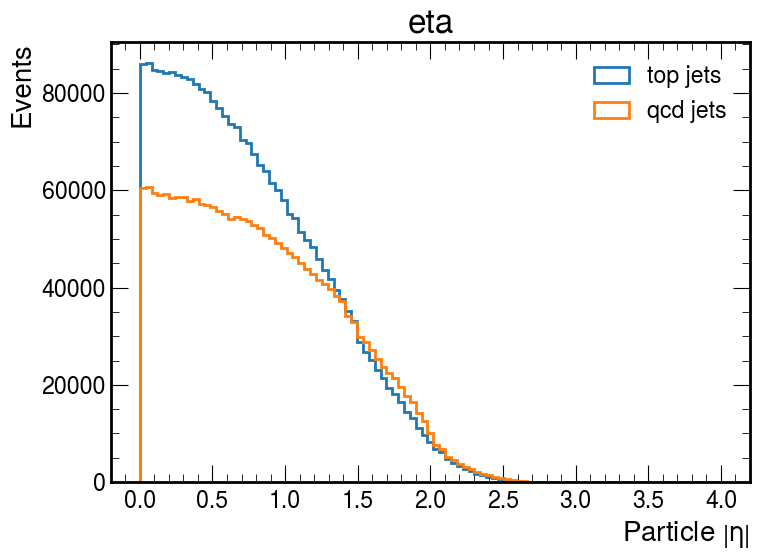

feature phi corresponding to index 1


100001it [00:20, 4846.63it/s]


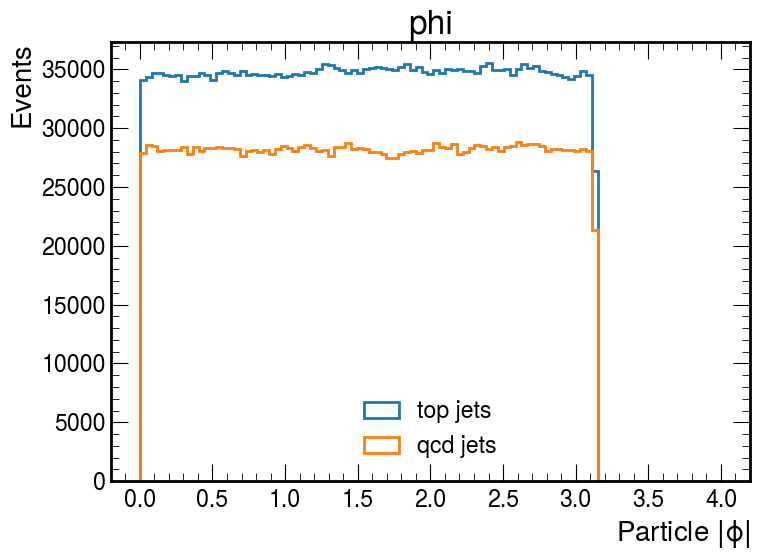

feature pt corresponding to index 2


100001it [00:11, 9066.71it/s]


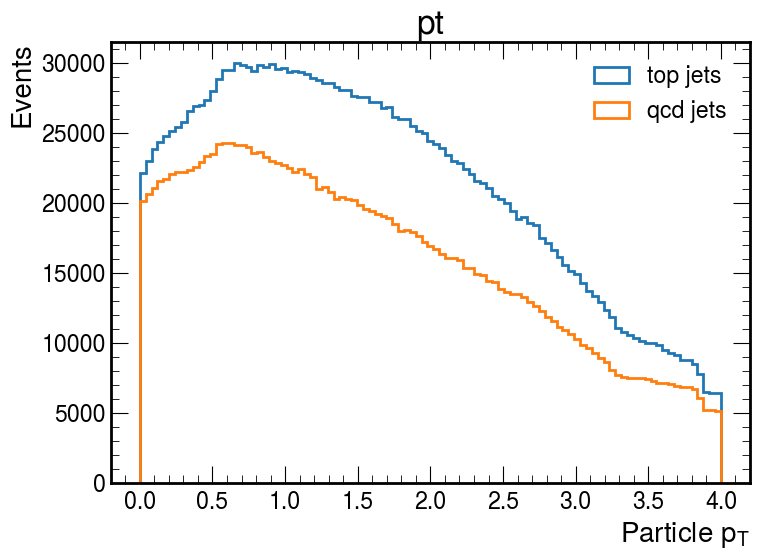

feature E corresponding to index 3


100001it [00:11, 8937.72it/s]


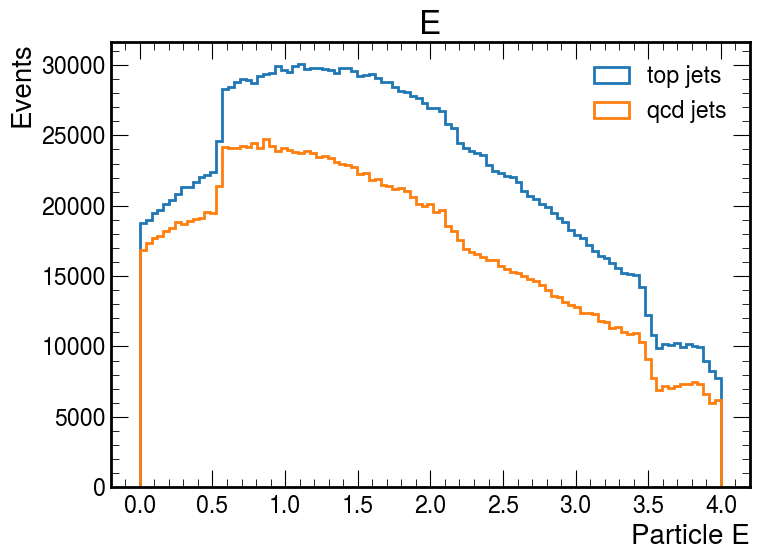

feature pt/jet_pt corresponding to index 4


100001it [00:11, 8669.26it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../plots/dataset_visaulization/preprocessed/pt/jet_pt_preprocessed_input_data_comparison.png'

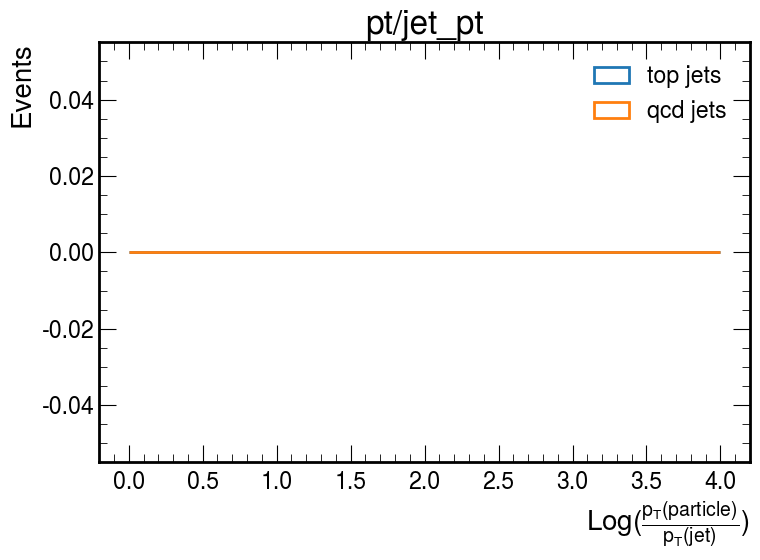

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import os
import mplhep as hep
from tqdm import tqdm

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})
save_dir = save_path = "../plots/dataset_visaulization/preprocessed"
os.system(f"mkdir -p {save_path}")  # -p: create parent dirs if needed, exist_ok
# Assuming 'v' is your dictionary and 'df' is a pandas DataFrame with labels
# Assuming 'px', 'py', 'pz', 'energy', 'p4', 'jet_p4', and 'n_particles' are already defined and filled
# Ensure 'save_dir' is defined and points to the desired save directory

for feature in feature_dict.keys():
    index = feature_dict[feature]
    print(f"feature {feature} corresponding to index {index}")
    
    # Prepare the figure for the current feature
    fig, ax = plt.subplots(figsize=(8, 6))
    
    features = {'top': [], 'qcd': []}

    # Collect features based on labels
    for jet, class_label in tqdm(zip(data_7, labels_7)):
        if class_label == 1:
            label = 'top'
        else:
            label = 'qcd'

        for particle in jet.T:
            if particle[index] != 0:
                if feature in ['pt', "E", "pt/jet_pt", "E/jet_E"]:
                    features[label].append(particle[index])
                else:
                    features[label].append(np.abs(particle[index]))

    # Plot histograms for the current feature
    ax.hist(features['top'], bins=np.linspace(0, 4, 100), histtype='step', linewidth=2, label=f"top jets")
    ax.hist(features['qcd'], bins=np.linspace(0, 4, 100), histtype='step', linewidth=2, label=f"qcd jets")

    # Set labels and title for the subplot
    ax.legend()
    ax.set_xlabel(feature_label[feature]);
    ax.set_ylabel(r"Events"); 
    ax.set_title(f"{feature}")

    # Adjust layout and show/save the plot for the current feature
    plt.tight_layout()
#     plt.suptitle(f"{feature}", y=1.02)
    plt.savefig(f"{save_path}/{feature}_preprocessed_input_data_comparison.png", bbox_inches='tight', dpi=300)
    plt.show()

In [20]:
data_7[:10, 1, :]

array([[ 2.57297826,  2.44473267,  2.45712948, ...,  0.        ,
         0.        ,  0.        ],
       [-1.28682399, -1.38332677, -1.26625144, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.4587121 ,  2.53639412,  2.52863646, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.79136658,  2.79223132,  2.67641687, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.42145169,  2.24618602,  1.65915918, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.7385872 ,  0.83884472,  0.72718018, ...,  0.        ,
         0.        ,  0.        ]])